In [1]:
import sys
from pathlib import Path

# 시각화
import plotly.express as px

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score

sys.path.append(str(Path.cwd().parent))
from utils import DATA_DIR

In [2]:
import platform
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

mpl.rcParams['axes.unicode_minus'] = False
# 폰트 개인 경로에 맞춰서 변경
# FONT_DIR = Path("/path/to/fonts")
# font_path = FONT_DIR / 'FREESENTATION-6SEMIBOLD.ttf'
# prop = fm.FontProperties(fname=font_path)

In [3]:
pandas_kwargs = {
    'parse_dates': ['검정일자'],
    'date_format': '%Y-%m-%d'
}

df: pd.DataFrame = pd.read_csv(DATA_DIR /'interim' / 'milk.csv', **pandas_kwargs)
df.head()

,농장아이디,개체번호,검정일자,누적착유일(연계),유지방율,유단백,무지고형분,체세포수,MUN,305일유량,...,공태일수,유량,질병군,우유등급,비유초기평균MUN.1,비유최고도달일수_log,건유전마지막유량_log,공태일수_log,출생년도,PF비
0,21133,2.007121e+13,2021-03-18,445,6.60,3.28,8.87,274,11.6,15158.0,...,619,76169939,0,2등급이하,NaN,4.143135,4.330733,6.429719,2007,0.496970
1,21133,2.007121e+13,2021-04-28,486,3.64,3.33,8.91,166,11.0,15158.0,...,619,76170244,0,1등급,NaN,4.143135,4.330733,6.429719,2007,0.914835
2,21133,2.007121e+13,2021-05-20,508,2.61,3.35,9.14,156,10.8,15158.0,...,619,76170487,0,1등급,NaN,4.143135,4.330733,6.429719,2007,1.283525
3,21133,2.007121e+13,2021-06-25,544,3.75,3.49,8.99,307,14.1,15158.0,...,619,76170734,0,2등급이하,NaN,4.143135,4.330733,6.429719,2007,0.930667
4,21133,2.007121e+13,2021-07-07,556,3.68,3.74,9.31,34,16.2,15158.0,...,619,76170903,0,1등급,NaN,4.143135,4.330733,6.429719,2007,1.016304


In [4]:
df.shape

(58441, 41)

In [5]:
df.info() # nan값은 pipeline으로 처리할 예정.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58441 entries, 0 to 58440
Data columns (total 41 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   농장아이디         58441 non-null  int64         
 1   개체번호          58441 non-null  float64       
 2   검정일자          58441 non-null  datetime64[ns]
 3   누적착유일(연계)     58441 non-null  int64         
 4   유지방율          42084 non-null  float64       
 5   유단백           42084 non-null  float64       
 6   무지고형분         42084 non-null  float64       
 7   체세포수          58441 non-null  int64         
 8   MUN           42084 non-null  float64       
 9   305일유량        43678 non-null  float64       
 10  305일유지량       43678 non-null  float64       
 11  305일유단백       43678 non-null  float64       
 12  305일무지고형분     43678 non-null  float64       
 13  성년유량          43678 non-null  float64       
 14  성년유지량         43678 non-null  float64       
 15  성년유단백량        43678 non-null  float6

In [6]:
df.describe()

,농장아이디,개체번호,검정일자,누적착유일(연계),유지방율,유단백,무지고형분,체세포수,MUN,305일유량,...,농후사료급여량(연계),공태일수,유량,질병군,비유초기평균MUN.1,비유최고도달일수_log,건유전마지막유량_log,공태일수_log,출생년도,PF비
count,58441.000000,5.844100e+04,58441,58441.000000,42084.000000,42084.000000,42084.000000,58441.000000,42084.000000,43678.000000,...,58441.000000,58441.000000,5.844100e+04,58441.000000,0.0,58440.000000,33724.000000,58441.000000,58441.000000,41919.000000
mean,20934.352663,2.016493e+13,2020-12-23 08:15:58.997963776,202.230643,4.170827,3.313077,8.838642,126.464845,14.392603,10720.070104,...,0.261529,124.274516,4.707034e+07,0.001044,NaN,4.355995,3.808339,3.464868,2016.334816,0.831584
min,20249.000000,2.007121e+13,2020-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,755.000000,...,0.000000,0.000000,1.000000e+00,0.000000,NaN,0.000000,0.000000,0.000000,2006.000000,0.217631
25%,20269.000000,2.015121e+13,2020-07-08 00:00:00,76.000000,3.630000,3.080000,8.580000,0.000000,11.900000,9384.000000,...,0.000000,0.000000,1.589173e+07,0.000000,NaN,3.912023,3.931826,0.000000,2015.000000,0.721709
50%,21137.000000,2.017042e+13,2020-12-21 00:00:00,188.000000,4.140000,3.300000,8.870000,38.000000,13.900000,10650.000000,...,0.000000,99.000000,6.066701e+07,0.000000,NaN,4.369448,4.077537,4.605170,2017.000000,0.805419
75%,21278.000000,2.018041e+13,2021-06-11 00:00:00,303.000000,4.680000,3.540000,9.150000,111.000000,16.500000,12035.000000,...,1.000000,193.000000,7.617652e+07,0.000000,NaN,4.875197,4.204693,5.267858,2018.000000,0.895151
max,21876.000000,2.021010e+13,2022-02-04 00:00:00,1101.000000,9.990000,8.900000,13.930000,20484.000000,57.200000,21284.000000,...,1.000000,974.000000,9.583738e+07,1.000000,NaN,6.643790,6.513230,6.882437,2020.000000,4.837838
std,585.808734,1.935616e+10,NaN,150.494690,0.960408,0.413767,0.709344,381.293975,3.789614,2031.349473,...,0.439471,126.059024,3.055409e+07,0.032291,NaN,0.819051,1.158737,2.370168,1.880170,0.209850


In [7]:
df['1등급'] = df['우유등급'].map({
    '1등급': 0,
    '2등급이하': 1
})

In [8]:
features = ['누적착유일(연계)', '전산차비유지속성', '현재산차비유지속성', '비유최고도달일수_log',
'건유전마지막유량_log', '전산차건유전유량', '출생년도', '산차', '농후사료비(연계)',
'농후사료급여량(연계)', '공태일수_log']

target = '1등급'

<Axes: xlabel='1등급', ylabel='산차'>

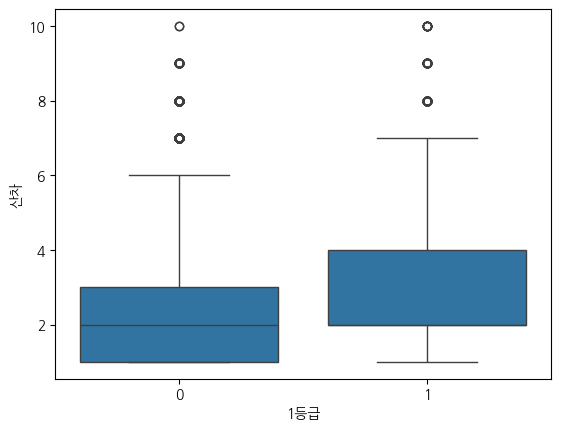

In [9]:
sns.boxplot(df, x=target, y='산차') # 우유등급별로 다른 결측치 처리를 해야겠음.

# 변수들 간의 상관관계 확인해서 review_score, monthly_avg_orders와 상관계수 높은 것들은 제거하거나 처리

In [10]:
vars = features + [target]
corr_matrix = df[vars].corr().round(3)

fig_corr = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    title="Correlation Matrix (Plotly)",
    template="plotly_dark"
)
fig_corr.update_layout(
    xaxis_title="Features",
    yaxis_title="Features",
    width=1200, height=1000
)
fig_corr.show()



In [11]:
# 농후사료급여량, 산차 살림
features.remove('농후사료비(연계)')
features.remove('출생년도')

features

['누적착유일(연계)',
 '전산차비유지속성',
 '현재산차비유지속성',
 '비유최고도달일수_log',
 '건유전마지막유량_log',
 '전산차건유전유량',
 '산차',
 '농후사료급여량(연계)',
 '공태일수_log']

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = df[features].dropna()

vif_data = pd.DataFrame({
    "Feature": features,
    "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]
})

fig_vif = px.bar(
    vif_data.sort_values("VIF", ascending=True),
    x="VIF",
    y="Feature",
    orientation="h",
    title="Variance Inflation Factor (VIF) — 다중공선성 진단",
    template="plotly_dark",
    color="VIF",
    color_continuous_scale="Viridis"
)
fig_vif.add_vline(x=5, line_dash="dash", line_color="orange",
                  annotation_text="주의 경계선 (VIF=5)")
fig_vif.add_vline(x=10, line_dash="dot", line_color="red",
                  annotation_text="심각 (VIF=10)")
fig_vif.show()

In [13]:
# 비유최고도달일수_log 제거
features.remove('비유최고도달일수_log')

# 피어슨, 스피어만 상관분석

In [16]:
from scipy.stats import spearmanr

for feature in features:
    print('='*50)
    print(f'{feature}와 {target} 상관분석')
    print('='*50)
    
    temp = df.dropna(subset=[feature])
    r, pval = spearmanr(temp[target], temp[feature])
    print(f"Pearson correlation: r = {r:.3f}, p-value = {pval:.5f}")
    print()

누적착유일(연계)와 1등급 상관분석
Pearson correlation: r = 0.084, p-value = 0.00000

전산차비유지속성와 1등급 상관분석
Pearson correlation: r = 0.075, p-value = 0.00000

현재산차비유지속성와 1등급 상관분석
Pearson correlation: r = 0.016, p-value = 0.00015

건유전마지막유량_log와 1등급 상관분석
Pearson correlation: r = 0.041, p-value = 0.00000

전산차건유전유량와 1등급 상관분석
Pearson correlation: r = -0.043, p-value = 0.00000

산차와 1등급 상관분석
Pearson correlation: r = 0.153, p-value = 0.00000

농후사료급여량(연계)와 1등급 상관분석
Pearson correlation: r = 0.002, p-value = 0.55798

공태일수_log와 1등급 상관분석
Pearson correlation: r = 0.055, p-value = 0.00000



# df train/test로 분리해야 함

In [ ]:
df[target].value_counts()

In [ ]:
df['검정일자'].dt.year.value_counts()

In [ ]:
train = df[df['검정일자'].dt.year == 2020]
test = df[df['검정일자'].dt.year == 2021]

In [ ]:
X_train, X_test = train[features], test[features]
y_train, y_test = train['우유등급'], test['우유등급']

# Pipeline 만들고 GridSearchCV 적용해서 best model 찾기!

SMOTE도 해보기

# 튜터님 조언: 단순 복제 oversampling 사용

In [ ]:
from imblearn.over_sampling import RandomOverSampler

## RF

## LightGBM

In [ ]:
import lightgbm as lgb
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")


RandomOverSampler 사용

In [ ]:
# Pipeline 구성 (RandomOverSampler + LightGBM)
pipeline = Pipeline([
    ('oversample', RandomOverSampler(random_state=42)),
    ('clf', lgb.LGBMClassifier(
        objective='multiclass',
        device='gpu',
        num_class=3,
        random_state=42
    ))
])

param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [5, 10, None],
    'clf__learning_rate': [0.05, 0.1],
    'clf__min_child_samples': [1, 5, 10],
    'clf__min_gain_to_split': [0, 0.01, 0.05]
}


# scoring 지표
scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy'
}

# GridSearchCV 설정
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring=scoring,
    refit='f1_macro',  # 최종 모델은 f1_macro 기준 선택
    cv=5,
    n_jobs=-1,
    verbose=2
)

# 학습
grid.fit(X_train, y_train)

In [ ]:
# 결과 요약
results = pd.DataFrame(grid.cv_results_)[
    ['param_clf__n_estimators', 'param_clf__max_depth', 'param_clf__learning_rate',
     'mean_test_f1_macro', 'mean_test_balanced_accuracy']
]
print("\nGridSearchCV 결과 요약:")
print(results)

print("\nBest params (기준: f1_macro):", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)

In [ ]:
# 테스트셋 성능 평가
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC (OvO, macro)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")

In [ ]:
# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

scale_pos_weight 사용

In [ ]:
from collections import Counter

counter = Counter(y_train)
print(counter)

# 기준 클래스 (다수 클래스)
major_class = 'group_0'
major_count = counter[major_class]

# scale_pos_weight 계산
scale_pos_weight = {cls: round(major_count / count, 2) for cls, count in counter.items()}
print(scale_pos_weight)

In [ ]:
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(counter),
    class_weight='scale_pos_weight',
    random_state=42
)

# 하이퍼파라미터 그리드
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'learning_rate': [0.05, 0.1],
    'min_child_samples': [1, 5, 10],
    'min_gain_to_split': [0, 0.01, 0.05]
}

# scoring 지표
scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy'
}

# GridSearchCV
grid = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2,
)

grid.fit(X_train, y_train)

In [ ]:
# 결과 요약
results = pd.DataFrame(grid.cv_results_)[
    ['param_n_estimators', 'param_max_depth', 'param_learning_rate',
     'mean_test_f1_macro', 'mean_test_balanced_accuracy']
]
print("\nGridSearchCV 결과 요약:")
print(results)

print("\nBest params (기준: f1_macro):", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)

In [ ]:
# 테스트셋 성능 평가
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC (OvO, macro)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")

In [ ]:
# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## class_weight='balanced', 하이퍼파라미터 튜닝 변경

In [ ]:
# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    class_weight='balanced',
    random_state=42
)

# 하이퍼파라미터 그리드
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.01, 0.05],
    'num_leaves': [31, 63],
    'min_child_samples': [1, 3, 5],
    'min_gain_to_split': [0, 0.01, 0.05]
}


# scoring 지표
scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy'
}

# GridSearchCV
grid = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2,
)

grid.fit(X_train, y_train)

In [ ]:
# 결과 요약
results = pd.DataFrame(grid.cv_results_)[
    ['param_n_estimators', 'param_max_depth', 'param_learning_rate',
     'mean_test_f1_macro', 'mean_test_balanced_accuracy']
]
print("\nGridSearchCV 결과 요약:")
print(results)

print("\nBest params (기준: f1_macro):", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)

In [ ]:
# 테스트셋 성능 평가
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC (OvO, macro)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")

In [ ]:
# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

randomoversampler 일부만, class_weight, 하이퍼파라미터 튜닝

In [ ]:
# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 일부만 RandomOverSampler 적용
# 소수 클래스 target 샘플 수 직접 지정
sampling_strategy = {
    'group_1': 1000,  # group_1 샘플 증가
    'else': 1000      # else 샘플 증가
}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

# LightGBM 파이프라인
pipeline = Pipeline([
    ('oversample', ros),
    ('clf', lgb.LGBMClassifier(
        objective='multiclass',
        is_unbalance=True,
        class_weight='balanced',
        num_class=3,
        random_state=42
    ))
]) # 분류 모델의 클래스 threshold 조정하여 낮은 확률이더라도 맞출 수 있도록 하기.

# 하이퍼파라미터 그리드
param_grid = {
    'clf__n_estimators': [200, 400],
    'clf__max_depth': [10, 20],
    'clf__learning_rate': [0.01, 0.05],
    'clf__num_leaves': [31, 63, 127],
    'clf__min_child_samples': [1, 3, 5],
    'clf__min_gain_to_split': [0, 0.01, 0.05]
}

# 평가 지표
scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy',
    'average_precision_macro': 'average_precision_macro'
}

# GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring=scoring,
    refit='average_precision_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# 학습
grid.fit(X_train, y_train)


In [ ]:
# 결과 요약
results = pd.DataFrame(grid.cv_results_)[
    ['param_clf__n_estimators', 'param_clf__max_depth', 'param_clf__learning_rate',
     'mean_test_f1_macro', 'mean_test_balanced_accuracy']
]
print("\nGridSearchCV 결과 요약:")
print(results)

print("\nBest params (기준: f1_macro):", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)

In [ ]:
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# 클래스 이름과 이진화
classes = grid.best_estimator_.named_steps['clf'].classes_
y_test_bin = label_binarize(y_test, classes=classes)

# 모델 확률 예측
y_prob = grid.predict_proba(X_test)  # shape = (n_samples, n_classes)

# 각 클래스별 최적 threshold 찾기
best_thresholds = {}
for i, cls in enumerate(classes):
    best_f1 = 0
    best_t = 0
    thresholds_to_try = np.linspace(0.1, 0.9, 81)  # 0.1~0.9까지 0.01 간격
    for t in thresholds_to_try:
        y_pred_cls = (y_prob[:, i] >= t).astype(int)
        f1 = f1_score(y_test_bin[:, i], y_pred_cls)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds[cls] = best_t
    print(f"Class {cls}: Best Threshold = {best_t:.2f}, Best F1 = {best_f1:.4f}")

# 최적 threshold 적용 후 멀티클래스 예측
y_pred_thresholded = []
for p in y_prob:
    # threshold 미만 확률은 0으로
    adjusted_p = np.array([prob if prob >= best_thresholds[cls] else 0
                           for cls, prob in zip(classes, p)])
    # 최대값 선택
    y_pred_thresholded.append(classes[np.argmax(adjusted_p)])
y_pred = np.array(y_pred_thresholded)

# 평가
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix

print("\nClassification Report (Threshold Optimized):")
print(classification_report(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro') # <- 조정해도 값이 바뀔 수 없는 건가? 순서 기준으로 점수를 매겨서 임계값과
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# PR-AUC 계산
pr_auc_dict = {}
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    pr_auc = auc(recall, precision)
    pr_auc_dict[cls] = pr_auc
    print(f"Class {cls} - PR-AUC: {pr_auc:.4f}")

pr_auc_macro = np.mean(list(pr_auc_dict.values()))
print(f"Macro-average PR-AUC: {pr_auc_macro:.4f}")

y_pred = np.array(y_pred)

In [ ]:
# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# SMOTE + LightGBM + class_weight + GridSearchCV

In [ ]:
from sklearn.metrics import make_scorer, average_precision_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE 설정 (소수 클래스 적절히 늘리기)
smote = SMOTE(
    sampling_strategy={'group_1': 400, 'else': 400},
    random_state=42
)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# LightGBM classifier
lgbm_clf = lgb.LGBMClassifier(
    objective='multiclass',
    class_weight='balanced',  # 소수 클래스 가중치 자동 적용
    n_jobs=-1,
    random_state=42
)

# GridSearchCV 파라미터
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [10, 20],
    'learning_rate': [0.01, 0.05],
    'num_leaves': [31, 63, 127],
    'min_child_samples': [1, 3, 5],
    'min_gain_to_split': [0, 0.01, 0.05]
}

scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy',
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=lgbm_clf,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_macro',
    cv=cv,
    n_jobs=-1
)

# 학습
grid.fit(X_train_res, y_train_res)

# 결과 확인
print("Best params:", grid.best_params_)
print("Best f1_macro:", grid.best_score_)

In [ ]:
# 테스트 세트 예측
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

# 테스트셋 성능 평가
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC (OvO, macro)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")

# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# 클래스 이름과 이진화
classes = grid.best_estimator_.classes_
y_test_bin = label_binarize(y_test, classes=classes)

# 모델 확률 예측
y_prob = grid.predict_proba(X_test)

# 각 클래스별 최적 threshold 찾기
best_thresholds = {}
for i, cls in enumerate(classes):
    best_f1 = 0
    best_t = 0
    thresholds_to_try = np.linspace(0.1, 0.9, 81)  # 0.1~0.9까지 0.01 간격
    for t in thresholds_to_try:
        y_pred_cls = (y_prob[:, i] >= t).astype(int)
        f1 = f1_score(y_test_bin[:, i], y_pred_cls)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds[cls] = best_t
    print(f"Class {cls}: Best Threshold = {best_t:.2f}, Best F1 = {best_f1:.4f}")

# 최적 threshold 적용 후 멀티클래스 예측
y_pred_thresholded = []
for p in y_prob:
    # threshold 미만 확률은 0으로
    adjusted_p = np.array([prob if prob >= best_thresholds[cls] else 0
                           for cls, prob in zip(classes, p)])
    # 최대값 선택
    y_pred_thresholded.append(classes[np.argmax(adjusted_p)])
y_pred = np.array(y_pred_thresholded)

# 평가
print("\nClassification Report (Threshold Optimized):")
print(classification_report(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# PR-AUC 계산
pr_auc_dict = {}
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    pr_auc = auc(recall, precision)
    pr_auc_dict[cls] = pr_auc
    print(f"Class {cls} - PR-AUC: {pr_auc:.4f}")

pr_auc_macro = np.mean(list(pr_auc_dict.values()))
print(f"Macro-average PR-AUC: {pr_auc_macro:.4f}")

In [ ]:
best_model = grid.best_estimator_

In [ ]:
best_model.feature_importances_

In [ ]:
# SPLIT
ax = lgb.plot_importance(best_model, max_num_features=3, importance_type='split')
ax.set(title=f'Feature Importance (split)',
	xlabel='Feature Importance',
	ylabel='Features')

# GAIN
ax = lgb.plot_importance(best_model, max_num_features=3, importance_type='gain')
ax.set(title=f'Feature Importance (gain)',
	xlabel='Feature Importance',
	ylabel='Features')

In [ ]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
fig = shap.summary_plot(shap_values, X_test)

In [ ]:
best_model.booster_.save_model('/content/drive/MyDrive/꾸러기_수비대/lgbm_booster.txt')

In [ ]:
import pickle

# 저장
with open('/content/drive/MyDrive/꾸러기_수비대/lgbm_pkl.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [ ]:
# 불러오기
with open('/content/drive/MyDrive/꾸러기_수비대/lgbm_pkl.pkl', 'rb') as f:
    loaded_clf = pickle.load(f)

In [ ]:
# 예측
y_pred = loaded_clf.predict(X_test)